<a href="https://colab.research.google.com/github/yukuproj/made3_bd/blob/main/hw5/hw5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install pyspark
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 31 kB/s 
     |████████████████████████████████| 199 kB 64.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=f0cba8ec913d1ca92077f119a94ebf3a584b403e9be962f260554d0f8cda49fb
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import HashingTF, IDF, Word2Vec
from pyspark.sql import SparkSession
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

class SparkTextModuleAnalys():
    def __init__(self):
        print("initialising...")
        os.environ['PYSPARK_PYTHON'] = sys.executable
        os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

        self.spark = SparkSession.builder\
                .master("local[*]")\
                .appName('PySpark_Tutorial')\
                .getOrCreate()

        self.data = None
        self.spark_dataframe = None

        self.idf = None
        self.idf_categories  = None
        self.idf_features_index = None

        self.w2v = None
        self.w2v_categories  = None
        self.w2v_sizes = None
        print("initialising...done")

    def read_data(self, file_name):
        print("read data...")
        self.data = pd.read_csv(file_name)
        print("read data...done")

    def clean_data(self):
        print("clean data..")
        self.data['comment_text'] = self.data['comment_text'].str.lower()
        self.data['comment_text'] = self.data['comment_text'].str.replace(r"[^a-z\']", ' ', regex=True).str.split()
        print("clean data..done")

    def make_spark_dataframe(self):
        print("making spark dataframe...")
        self.spark_dataframe = self.spark.createDataFrame(self.data)
        print("making spark dataframe...done")

    def make_idf(self, categories, features_index):    
        print("making idf...")
        self.idf_categories  = categories
        self.idf_features_index = features_index

        res = {_: [] for _ in categories}
        for feature_one_index in features_index:
            for cat in categories:
                hashingTF = HashingTF(inputCol="comment_text", outputCol="rawFeatures", numFeatures=feature_one_index)

                data_featured = hashingTF.transform(self.spark_dataframe)

                idf = IDF(inputCol="rawFeatures", outputCol="features")

                idf_model = idf.fit(data_featured)

                data_featured_rescaled = idf_model.transform(data_featured)

                lr = LogisticRegression(featuresCol='rawFeatures', labelCol=cat)

                evaluator = BinaryClassificationEvaluator(labelCol=cat)

                grid = ParamGridBuilder().addGrid(lr.maxIter, [0, 1]).build()

                cv = CrossValidator(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator,  parallelism=4)
                
                cv_model = cv.fit(data_featured_rescaled)

                res[cat].append(cv_model.avgMetrics[1])

        self.idf = res
        print("making idf...done") 

    def plot_idf(self):
        print("plotting...")
        for cat in self.idf_categories :
            plt.plot(self.idf_features_index, self.idf[cat])
        plt.legend(self.idf_categories )
        plt.xlabel('feature_index')
        plt.ylabel('metric')

    def make_w2v(self, categories, sizes): 
        print("making w2v...")
        self.w2v_categories  = categories
        self.w2v_sizes = sizes
        
        res = {_: [] for _ in categories}

        for size in sizes:
            for cat in categories:
                print("making w2v..." + " size=" + str(size)+"  category="+ str(cat))
                print("making w2v..." + " size=" + str(size)+"  category="+ str(cat)+ " word2Vec starting...")
                word2Vec = Word2Vec(vectorSize=size, minCount=0, inputCol="comment_text", outputCol="Word2Vec")
                print("making w2v..." + " size=" + str(size)+"  category="+ str(cat)+ " word2Vec starting...done")

                print("fit model starting...")
                model = word2Vec.fit(self.spark_dataframe)
                print("fit model starting... done")

                print("transforming starting...")
                result = model.transform(self.spark_dataframe)
                print("transforming starting...done")

                print("logistic regression starting...")
                lr = LogisticRegression(featuresCol='Word2Vec', labelCol=cat)
                print("logistic regression starting...done")

                print("evaluation starting...")
                evaluator = BinaryClassificationEvaluator(labelCol=cat)
                print("evaluation starting...done")


                print("grid starting...")
                grid = ParamGridBuilder().addGrid(lr.maxIter, [0, 1]).build()
                print("grid starting...done")

                print("cv starting...")
                cv = CrossValidator(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator,  parallelism=4)
                print("cv starting...done")

                print("cv model result starting...")
                cvModel = cv.fit(result)
                print("cv model result starting...done")
                res[cat].append(cvModel.avgMetrics[1])

        self.w2v = res

    def plot_w2v(self):
        for cat in self.w2v_categories:
            plt.plot(self.w2v_sizes, self.w2v[cat])
        plt.legend(self.w2v_categories)
        plt.xlabel('vsize')
        plt.ylabel('metric')

In [4]:
    current_analys = SparkTextModuleAnalys()
    file_name = "/content/drive/MyDrive/data/train.csv" 
    current_analys.read_data(file_name)
    current_analys.clean_data()
    current_analys.make_spark_dataframe()

initialising...
initialising...done
read data...
read data...done
clean data..
clean data..done
making spark dataframe...
making spark dataframe...done


initialising...
initialising...done
read data...
read data...done
clean data..
clean data..done
making spark dataframe...
making spark dataframe...done
making idf...
making idf...done
plotting...


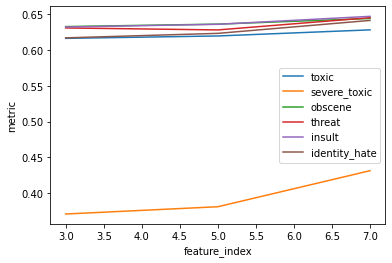

In [ ]:
current_analys.make_idf(categories = ['toxic' , 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'],
                            features_index = [3, 5, 7])
current_analys.plot_idf()

In [ ]:
    
#w2v
current_analys.make_w2v(categories = ['toxic' , 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'],
                            sizes = [3, 5, 7])
current_analys.plot_w2v()

making w2v...


making w2v...
making w2v... size=3  category=toxic
making w2v... size=3  category=toxic word2Vec starting...
making w2v... size=3  category=toxic word2Vec starting...done
fit model starting...
fit model starting... done
transforming starting...
transforming starting...done
logistic regression starting...
logistic regression starting...done
evaluation starting...
evaluation starting...done
grid starting...
grid starting...done
cv starting...
cv starting...done
cv model result starting...
cv model result starting...done
making w2v... size=5  category=toxic
making w2v... size=5  category=toxic word2Vec starting...
making w2v... size=5  category=toxic word2Vec starting...done
fit model starting...
fit model starting... done
transforming starting...
transforming starting...done
logistic regression starting...
logistic regression starting...done
evaluation starting...
evaluation starting...done
grid starting...
grid starting...done
cv starting...
cv starting...done
cv model result starting..

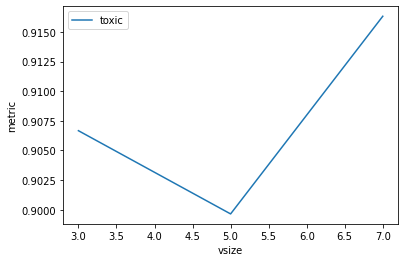

In [ ]:
#w2v
current_analys.make_w2v(categories = ['toxic'],
                            sizes = [3, 5, 7])
current_analys.plot_w2v()

We can see that the quality is much bigger (~90%) than in idf model for model with only one category. (to run model with multi label is very time-consuming. In colab.research.google.com it took me several hours to run the model and it hadn't yet completed, so it's reasonable to run only simplier models with only two classes)

making w2v...
making w2v... size=3  category=severe_toxic
making w2v... size=3  category=severe_toxic word2Vec starting...
making w2v... size=3  category=severe_toxic word2Vec starting...done
fit model starting...
fit model starting... done
transforming starting...
transforming starting...done
logistic regression starting...
logistic regression starting...done
evaluation starting...
evaluation starting...done
grid starting...
grid starting...done
cv starting...
cv starting...done
cv model result starting...
cv model result starting...done
making w2v... size=5  category=severe_toxic
making w2v... size=5  category=severe_toxic word2Vec starting...
making w2v... size=5  category=severe_toxic word2Vec starting...done
fit model starting...
fit model starting... done
transforming starting...
transforming starting...done
logistic regression starting...
logistic regression starting...done
evaluation starting...
evaluation starting...done
grid starting...
grid starting...done
cv starting...
cv 

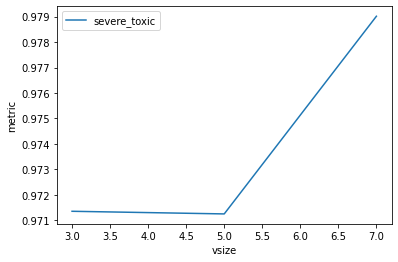

In [5]:
#w2v
current_analys.make_w2v(categories = ['severe_toxic'],
                            sizes = [3, 5, 7])
current_analys.plot_w2v()

As we can see the qualtity is much bigger than in idf model as well. AUROC = 97%
